## Plots graph edit distance figures for molecule case easy

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Arial'})

import numpy as np
import os, re, sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
case_name = "case_easy"

In [3]:
def sum_abs_adj_matrix(m):
    return sum(sum(np.abs(m)))/2

In [4]:
for dirs in ["case_easy"]:
    if not os.path.exists(f"./figures/{dirs}"):
        os.makedirs(f"./figures/{dirs}")

### various graphing colors

In [5]:
# synthia graph colors
synthia_purple = np.array([80,50,145,255])/255
synthia_blue = np.array([45,190,205,255])/255
synthia_orange = np.array([255,160,0,255])/255
synthia_pink = np.array([235,60,150,255])/255

In [6]:
# chemdraw step marker colors
cdraw_orange_face = np.array([252,236,207,255])/255
cdraw_orange_edge = np.array([245,191,94,255])/255

In [7]:
# gridline color
grid_grey = np.array([225,225,225,255])/255

## initialize

In [8]:

def process_route(r1):
    
    """
    processes matrix-encoded synthetic route.
    
    input: r1, a 3D array, where each layer is a matrix encoding a synthetic intermediate.
    output: a dictionary of route metrics. 
        diffs - the graph edit distance from each intermediate to the target
        step diffs - the graph edit distance from each intermediate to the one right after
        slope - the difference between consecutive entries of the diffs array
    """
    recording = open(f"./figures/{case_name}/route_recording.txt","w")
    total_diffs = []

    stereo_dists = []
    final_stereo = np.diag(r1[-1].copy())
    recording.write(f"final stereo: \n{final_stereo}\n")
    
    # get a version with blank diagonals (since stereochem is processed separately)
    final_bonds = r1[-1].copy()
    recording.write(f"final bonds:\n{final_bonds}\n")
    recording.write("get a version with blank diagonals (since stereochem is processed separately)\n")
    np.fill_diagonal(final_bonds, 0)
    recording.write(f"final bonds:\n{final_bonds}\n")
    
    # iterate through intermediates (from reactants to product):
    for i, raw_mat in enumerate(r1):
        recording.write(f"intermediate: {i+1}\n")
        recording.write(f"raw mat:\n{raw_mat}\n")
        # calculate stereochem distance 
        recording.write("calculate stereochem distance \n")

        stereo_data = np.diag(raw_mat.copy())
        recording.write(f"stereo_data:{stereo_data}\n")

        # stereochem distance
        # number of atoms where stereo differs
        # (stemoamide case, final has 4 stereocenters, this raw_mat intermediate has 0, so distance is 4)
        stereo_dist = sum(stereo_data != final_stereo)
        recording.write(f"stereo dist:{stereo_dist}\n")

        stereo_dists.append(stereo_dist)
        recording.write(f"stereo dists so far:{stereo_dists}\n")
        
        # get bonds only (without stereo)
        recording.write("get bonds only (without stereo)\n")
        mat = raw_mat.copy()
        np.fill_diagonal(mat, 0)
        recording.write(f"mat:\n{mat}\n")
        
        # bond distance
        diff = final_bonds - mat
        recording.write(f"diff:\n{diff}\n")
        
        # get bond edit distance
        # take all absolute values, sum them up, divide by 2
        recording.write("get bond edit distance\n take all absolute values, sum them up, divide by 2\n")
        total_diff_abs = sum_abs_adj_matrix(diff)
        recording.write(f"total_diff_abs:{total_diff_abs}\n")
        
        # append sum of bond and stereochem distance
        total_diffs.append(total_diff_abs + stereo_dist)
        recording.write(f"total_diffs so far:{total_diffs}\n")

    recording.write(f"final stereo dists:{stereo_dists}\n")
    step_diffs = []
    stereo_diffs = np.ediff1d(stereo_dists) # difference in stereochem distance between consecutive intermediates
    recording.write(f"stereo_diffs:{stereo_diffs}\n")
    for i_mat in range(len(r1)-1):
        # difference between 2 intermediates
        step_diff = r1[i_mat+1] - r1[i_mat]
        
        # zero out the stereochem 
        np.fill_diagonal(step_diff, 0)
        
        # total bond and stereocenter edits between 2 consecutive intermediates 
        # the reason to kick out diagnonal (stereochem) is because this is a diagonal matrix
        # the sum_abs_adj_matrix function would NOT count the diagonal entries twice, and the division by 2 would mess up the count
        total_diff_abs = sum_abs_adj_matrix(step_diff) + abs(stereo_diffs[i_mat])
        print(sum_abs_adj_matrix(step_diff),abs(stereo_diffs[i_mat]))

        step_diffs.append(total_diff_abs)

    # change in actual distance between intermediates 
    recording.write(f"step_diffs:{step_diffs}\n")
    slope = -np.ediff1d(total_diffs)
    recording.write(f"total_diffs:{total_diffs}\n")
    recording.write(f"slope:{slope}\n")

    return {"diffs":total_diffs,"step_diffs":step_diffs,"slopes":slope}
    

In [9]:
def graph_data(input_filename, highlight_steps=[], hl_only=False,
               step_labels=None, table_scale=(0.3,1), gridlines=None, 
               savename=None,plt_title=None):
    
    """
    produces plot of graph edit distances for a synthetic route.
    
    inputs:
    
    input_filename: string, path to the .npz file of the synthetic route matrices
    
    hightlight_steps: list of step numbers to plot in orange.
    
    hl_only: boolean. Whether to only annotate step numbers for highlighted steps
    
    step_labels: list, used to override the default step labels
    
    table_scale: (x,y) tuple, scaling factor for the slope table. Set to None to omit.
    
    gridlines: a dictionary of {"x":[list of x indices],"y":[list of y indices]},
        where grey gridlines will be drawn at the indicated locations.
        
    savename: string, path to save figure image
    
    plt_title: string, for titling the graph.
    """
    amats = np.load(input_filename)["amats"]
    to_plot  = process_route(amats)["diffs"]

    # compute values for the slope table
    slope = -np.array(process_route(amats)["slopes"]).astype("int")
    
    # swap to em dash
    slope_plot = []
    for slp in slope:
        if slp >= 0:
            slope_plot.append(slp)
        else:
            slope_plot.append("−"+str(slp)[1:])

    # the case for a 4-column table
    if len(slope) >= 10:
        # even 
        if len(slope) % 2 == 0:
            table_tags = np.arange(1,len(slope)+1,1)
            table_midpt = int(len(slope)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                          slope_plot[0:table_midpt],
                                          table_tags[table_midpt:],
                                          slope_plot[table_midpt:]))
        # odd    
        else:
            slope1 = slope_plot + ["-"]
            table_tags = np.append(np.arange(1,len(slope1),1),"-")
            table_midpt = int(len(slope1)/2)
            table_text = np.column_stack((table_tags[0:table_midpt],
                                              slope1[0:table_midpt],
                                          table_tags[table_midpt:],
                                              slope1[table_midpt:]))        

    # regular
    else: 
        table_text = np.vstack((np.arange(1,len(slope)+1,1),slope_plot)).transpose()

    # for step numbers
    y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
    x_midpoints = np.arange(0.5,len(to_plot)-1,1)

    
    fig,ax = plt.subplots(figsize=(3.5,2))

    mks = 4
    fs = 11 # table and tick labels
    label_fs = 11 # axis labels
    circle_fs = 7
    
    # re-plot highlighted steps as orange
    ax.plot(to_plot,marker="o",markersize=mks,color="grey",mfc="k",mec="k")
    for hl in highlight_steps:
        ax.plot([hl-1,hl],to_plot[hl-1:hl+1],color=synthia_orange,marker="o",markersize=mks,mfc="k",mec="k",linewidth=2)
        
    if gridlines:
        transX = ax.get_xaxis_transform()
        transY = ax.get_yaxis_transform()
        ax.vlines(gridlines["x"],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
        ax.hlines(gridlines["y"],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

    # put in the table - colLabels will be fine with a 2-column.
    if table_scale:
        slope_table = ax.table(cellText=table_text,
                              colLabels=["Step","Slope","Step","Slope"],
                              loc='right',fontsize=fs)

        slope_table.scale(*table_scale)

    # the step circles
    y_adj = 0
    
    # if no override, the labels are just the step number
    if not step_labels:
        step_labels = range(1,len(slope)+1)

    # for only plotting the highlighted steps
    if hl_only:
        hl_inds = [i-1 for i in highlight_steps]
        ax.scatter(x_midpoints[hl_inds],y_midpoints[hl_inds]+y_adj,s=75,
                   color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for hl in hl_inds:
            x_c = x_midpoints[hl]
            y_c = y_midpoints[hl]+y_adj
            label = ax.annotate(step_labels[hl], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # for all the steps
    else:
        ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

        for i in range(len(x_midpoints)):
            x_c = x_midpoints[i]
            y_c = y_midpoints[i]+y_adj

            label = ax.annotate(step_labels[i], xy=(x_c,y_c), fontsize=circle_fs,ha="center",va="center",fontweight="bold")

    # xy labels 
    ax.set_xticks(range(len(to_plot)))
    ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)
    
    y_max = np.int8( np.ceil(max(to_plot)/5) * 5 + 1 )
    ax.set_yticks(range(0,y_max,5))
    ax.set_yticklabels(range(0,y_max,5),font="Arial",fontsize=fs)

    ax.set_ylabel("Graph Edit Distance",fontsize=label_fs)
    ax.set_xlabel("Intermediate",fontsize=label_fs)
    
    if plt_title:
        plt.title(plt_title,fontsize=label_fs)
    
    if savename:
        plt.savefig(savename,dpi=600,bbox_inches = "tight")



### load matrix data


<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
C:\Users\U1093432\AppData\Local\Temp\ipykernel_6372\2709928874.py:9: SyntaxWarning: invalid escape sequence '\W'
  output_title = re.split("\W+",input_filename)[-2]


3.0 1
5.0 2
2.0 1
2.0 0
2.0 0
2.0 0
2.0 0
3.0 1
5.0 2
2.0 1
2.0 0
2.0 0
2.0 0
2.0 0


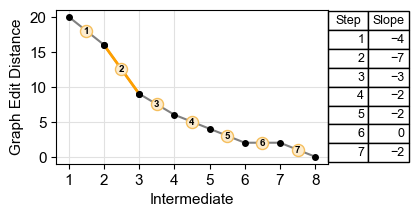

In [ ]:
# input_filename = "./matrices/stemo_synthia_mannich.npz"
input_filename = "./matrices/case_easy.npz"
highlight_steps = [2]
hl_only = False
step_labels = None

table_scale = (0.3,1.13)
gridlines = {"x":[0,1,2,3],"y":[0,5,10]}

output_title = re.split("\W+",input_filename)[-2]

savename=f"./figures/{case_name}/{output_title}.png"

graph_data(input_filename, highlight_steps, hl_only, step_labels, table_scale, gridlines, savename=savename)

In [ ]:
# exp1 = np.load("./matrices/case_easy.npz")["amats"]
# e1_data = process_route(exp1)
# e1_data

### plot graphs separately


the plotting code here is slightly raw. For a better-annotated function, see the notebook for plotting SI figures.

### Experimental PRN473

In [ ]:
# to_plot = e1_data["diffs"]
# to_plot

In [ ]:
# # these are for the step number markers, not really important.
# y_midpoints = np.array([np.mean([to_plot[i],to_plot[i+1]]) for i in range(len(to_plot)-1)])
# x_midpoints = np.arange(0.5,len(to_plot)-1,1)
# print("x_midpoints:", x_midpoints)
# print("y_midpoints:", y_midpoints)

In [ ]:
# fig,ax = plt.subplots(figsize=(3.5,2))

# mks = 4
# fs = 7
# label_fs = 7

# # plot distances
# ax.plot(to_plot,marker="o",color="grey",markersize=mks,mfc="k",mec="k")

# # plot highlighted steps
# ax.plot([1,2],to_plot[1:3],color=synthia_orange,marker="o",markersize=mks,mfc="k",mec="k",linewidth=2)


# ax.set_xticks(range(len(to_plot)))
# ax.set_xticklabels(range(1,len(to_plot)+1),fontsize=fs)
# ax.set_yticks(range(0,21,5))
# ax.set_yticklabels(range(0,21,5),fontsize=fs)
# ax.set_ylabel("Graph Edit Distance",fontsize=label_fs)
# ax.set_xlabel("Intermediate",fontsize=label_fs)

# # for the yellow circles with step numbers.
# # can adjust step number label height. can be array if custom adjustments are needed
# y_adj = 0
# ax.scatter(x_midpoints,y_midpoints+y_adj,s=75,color=cdraw_orange_face,edgecolors=cdraw_orange_edge,zorder=3)

# for i in range(len(x_midpoints)):
#     x_c = x_midpoints[i]
#     y_c = y_midpoints[i]+y_adj

#     label = ax.annotate(i+1, xy=(x_c,y_c), fontsize=6,ha="center",va="center",fontweight="bold")

# transX = ax.get_xaxis_transform()
# transY = ax.get_yaxis_transform()
# ax.vlines([1,3,5,7],ymin=0,ymax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transX)
# ax.hlines([0,5,10,15,20],xmin=0,xmax=1,color=grid_grey,zorder=0,linewidth=0.8,transform=transY)

# plt.savefig(f"./figures/main/{case_name}.svg",bbox_inches = "tight")